#### **Imports**

In [252]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

colors = ['crimson','midnightblue', 'violet','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

#### **Exercise 1**

In [253]:
def likelihood(x,alpha,beta):
    pdf = 1 + alpha*x + beta*x**2    
    norm = (6859 * beta + 22800) / 12000
    return np.where(np.abs(x) <= 0.95, pdf/norm, 0.)

def likelihood_changed_limits(x,alpha,beta):
    pdf = 1 + alpha*x + beta*x**2    
    norm = (6859 * beta + 22800) / 12000
    return np.where(np.logical_and(-0.9 <= x, x <= 0.85), pdf/norm, 0.)

def log_likelihood(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def log_likelihood_0(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=0)

def gen_MC(alpha,beta,_num_samples):
    
    #We will define a simple linear space in x and evaluate the PDF over this range.
    xrange = np.linspace(-0.95,0.95,100)
    pdf_curve = likelihood(xrange,alpha,beta)

    #Next, we will find where the PDF evaluated on xrange has its maximum.
    #This will be our upper boundary for the accept-reject box; the lower boundary is 0.
    max_value = np.max(pdf_curve)
    min_value = 0

    #We sample uniformly from both x and the "pdf" (in reality just a variable that goes along the y-axis) to 
    #populate the accept-reject box.
    x_samples = np.random.uniform(-0.95,0.95,_num_samples)
    pdf_samples = np.random.uniform(min_value,max_value,_num_samples)

    #Then, we will actually evaluate the PDFs at our x_samples given the likelihood function we defined.
    evaluated_pdfs_at_x = likelihood(x_samples,alpha,beta)
    #The accept-reject test will be passed if our "pdf samples" are below the actual PDF.
    accept_inds = np.where(evaluated_pdfs_at_x - pdf_samples > 0)[0]
    reject_inds = np.where(evaluated_pdfs_at_x - pdf_samples < 0)[0]
    
    return x_samples[accept_inds],pdf_curve

In [254]:
df_ab = pd.read_csv('ParameterEstimation_Ex1.txt',header=None)
df_ab.columns = ['Data']
data_array = df_ab['Data'].values

In [255]:
lambda_neg_LLH = lambda params: -log_likelihood(data_array,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res = minimize(lambda_neg_LLH,x0=[0.4,0.4],bounds=((0,1),(0,1)),method='L-BFGS-B')
errors = np.sqrt(np.diag(res.hess_inv.todense()))

min_a , min_b = res.x

print(f'GET HELP')
print(f'After minimization, alpha was found to {min_a:.05} with error {errors[0]:.04}, and beta to be {min_b:.05} with error {errors[1]:.04}')

GET HELP
After minimization, alpha was found to 0.33316 with error 0.04631, and beta to be 0.0 with error 0.1147


Text(0, 0.5, '$f(x)$')

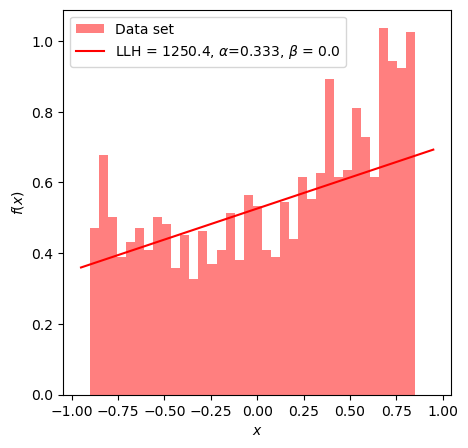

In [256]:
plt.figure(figsize = (5,5))

x_range = np.linspace(-0.95,0.95,2000)

plt.hist(data_array,bins=np.linspace(-0.95,0.95,30),density=True,alpha=0.5,label = 'Data set',color='red')
plt.plot(x_range,likelihood(x_range,alpha=min_a,beta=min_b),
         label=fr'LLH = {res.fun:.05}, $\alpha$={min_a:.03}, $\beta$ = {min_b:.03}',linestyle='-',color='red')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [257]:
N = 500 # How many pseudo-trials
MC_per_iter = 2000 # How many MC points to be generated per pseudo-trial
new_true_alpha = 0.5 # True alpha value
new_true_beta = 0.5  # True beta value

pseudo_alpha , pseudo_beta = [] , []

for i in range(N):
    
    generated_samples,generated_pdf = gen_MC(alpha=new_true_alpha,beta=new_true_beta,_num_samples=MC_per_iter)
    
    lambda_neg_LLH = lambda params: -2*log_likelihood(generated_samples,
                                np.expand_dims([params[0]],axis=0),np.expand_dims([params[1]],axis=1))

    res = minimize(lambda_neg_LLH,x0=[0.5,0.5],bounds=((0,1),(0,1)),method='L-BFGS-B')
    errors = np.sqrt(np.diag(res.hess_inv.todense()))

    min_a , min_b = res.x

    pseudo_alpha.append(min_a)
    pseudo_beta.append(min_b)

**Fixing alpha**

In [258]:
def likelihood_fixed_alpha(x, beta):
    alpha = 0.65  # Fixed value
    pdf = 1 + alpha*x + beta*x**2
    norm = (6859 * beta + 22800) / 12000
    return np.where(np.abs(x) <= 0.95, pdf/norm, 0.)

# Adjusted log likelihood function for a fixed alpha
def log_likelihood_fixed_alpha(x, beta):
    return np.sum(np.log(likelihood_fixed_alpha(x, beta)), axis=0)

fixed_pseudo_beta = []

for i in range(N):
    
    generated_samples,generated_pdf = gen_MC(alpha=0.65,beta=new_true_beta,_num_samples=MC_per_iter)

    # Adjusted negative log likelihood function for optimization
    lambda_neg_LLH_fixed_alpha = lambda beta: -log_likelihood_fixed_alpha(data_array, beta)

    # Optimization for beta only, with alpha fixed at 0.5
    res_fixed_alpha = minimize(lambda_neg_LLH_fixed_alpha, x0=[0.4], bounds=[(0, 1)], method='L-BFGS-B')
    errors_fixed_alpha = np.sqrt(np.diag(res_fixed_alpha.hess_inv.todense()))

    fixed_pseudo_beta.append(res_fixed_alpha.x[0])

**Exercise 1b**

In [259]:
alpha_low, alpha_high = np.percentile(pseudo_alpha, [15.865, 84.135])
beta_low, beta_high = np.percentile(pseudo_beta, [15.865, 84.135])
fixed_beta_low, fixed_beta_high = np.percentile(fixed_pseudo_beta, [15.865, 84.135])

In [260]:
print(f'For alpha fits, the one-sigma interval is {alpha_high - alpha_low:.03}')
print(f'For beta fits, the one-sigma interval is {beta_high - beta_low:.03}')
print(f'For beta fitting with alpha fixed, the one-sigma interval is {fixed_beta_high - fixed_beta_low:.03}')

For alpha fits, the one-sigma interval is 0.144
For beta fits, the one-sigma interval is 0.29
For beta fitting with alpha fixed, the one-sigma interval is 0.0


**Plotting**

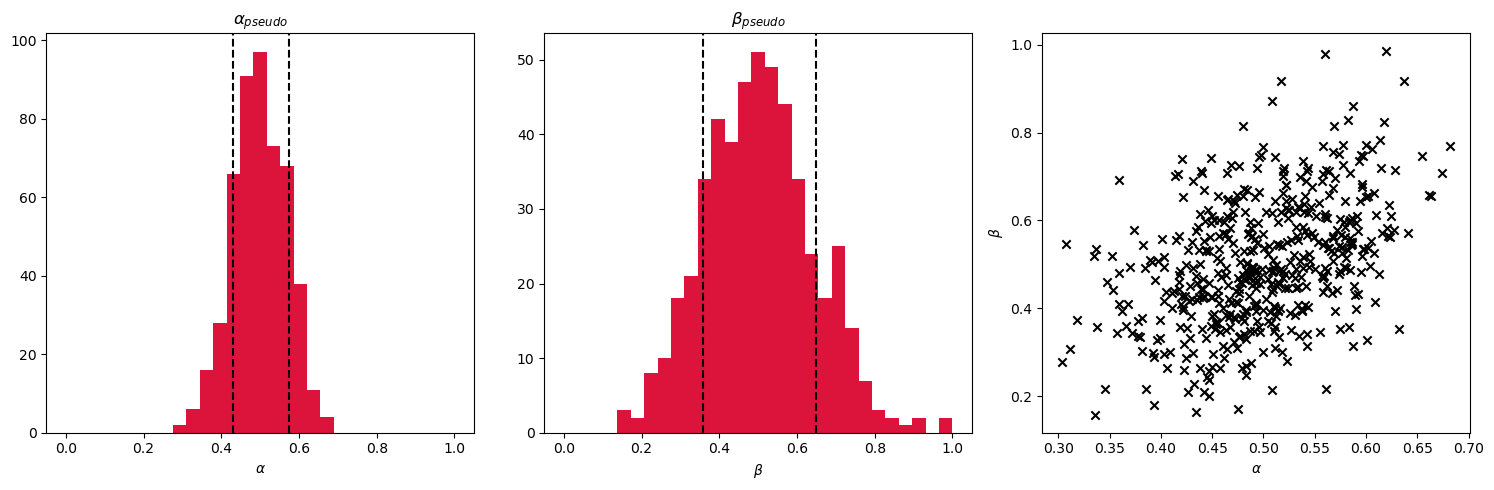

In [261]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(pseudo_alpha,bins=np.linspace(0.,1.,30),density=False,label = r'${\alpha}_{pseudo}$')
ax[0].set_title(r'${\alpha}_{pseudo}$')
ax[0].set_xlabel(r'$\alpha$')  # Set x-axis label
ax[0].axvline(x=alpha_low, color='k', linestyle='--')
ax[0].axvline(x=alpha_high, color='k', linestyle='--')

ax[1].hist(pseudo_beta,bins=np.linspace(0.,1.,30),density=False,label = r'${\beta}_{pseudo}$')
ax[1].set_title(r'${\beta}_{pseudo}$')
ax[1].set_xlabel(r'$\beta$')  # Set x-axis label
ax[1].axvline(x=beta_low, color='k', linestyle='--')
ax[1].axvline(x=beta_high, color='k', linestyle='--')

ax[2].scatter(pseudo_alpha,pseudo_beta,marker='x',color='black')
ax[2].set_xlabel(r'$\alpha$')  # Set x-axis label
ax[2].set_ylabel(r'$\beta$')  # Set x-axis label

plt.tight_layout()
plt.show()

**Exercise 1c**

In [262]:
# Define the log likelihood function for a fixed alpha
def log_likelihood_fixed_alpha(x, beta):
    alpha = 0.65  # Fixed value
    pdf = 1 + alpha*x + beta*x**2
    norm = (6859 * beta + 22800) / 12000
    likelihood = np.where(np.logical_and(-0.95 < x, x < 0.95), pdf/norm, 0.)
    return np.sum(np.log(likelihood))

# Find beta that maximizes the log likelihood (i.e., find the best-fit beta)
res = minimize(lambda beta: -log_likelihood_fixed_alpha(data_array, beta), 
               x0=[0.5], bounds=[(0, 1)], method='L-BFGS-B')

beta_best_fit = res.x[0]
LLH_best_fit = -res.fun  # Log likelihood at the best-fit value

# Find the values of beta that give a log likelihood of LLH_best_fit - 0.5
def find_beta_confidence_interval(beta_best_fit, LLH_best_fit, sign):
    func = lambda beta: np.abs(log_likelihood_fixed_alpha(data_array, beta) - (LLH_best_fit - 0.5))
    result = minimize(func, x0=beta_best_fit + sign * 0.1, bounds=[(0, 1)], method='L-BFGS-B')
    return result.x[0]

beta_upper = find_beta_confidence_interval(beta_best_fit, LLH_best_fit, 1)
beta_lower = find_beta_confidence_interval(beta_best_fit, LLH_best_fit, -1)

sigma_beta_plus = beta_upper - beta_best_fit
sigma_beta_minus = beta_best_fit - beta_lower

print(f'The best beta fit was {beta_best_fit:.03}, sigma+ was {sigma_beta_plus:.03} and sigma- was {sigma_beta_minus:.03}')

The best beta fit was 0.347, sigma+ was 0.0853 and sigma- was 0.0798


#### **Exercise 2**

In [263]:
N = 500 # How many pseudo-trials
MC_per_iter = 2000 # How many MC points to be generated per pseudo-trial
new_true_alpha = 0.5 # True alpha value
new_true_beta = 0.5  # True beta value

pseudo_alpha , pseudo_beta , LLH = [] , [] , []

for i in range(N):
    
    generated_samples,generated_pdf = gen_MC(alpha=new_true_alpha,beta=new_true_beta,_num_samples=MC_per_iter)
    
    lambda_neg_LLH = lambda params: -log_likelihood(generated_samples,
                                np.expand_dims([params[0]],axis=0),np.expand_dims([params[1]],axis=1))

    res = minimize(lambda_neg_LLH,x0=[0.5,0.5],bounds=((0,1),(0,1)),method='L-BFGS-B')
    errors = np.sqrt(np.diag(res.hess_inv.todense()))

    min_a , min_b = res.x

    pseudo_alpha.append(min_a)
    pseudo_beta.append(min_b)
    LLH.append(res.fun)

In [264]:
new_true_alpha = 0.5
new_true_beta = 0.5

In [265]:
alpha_range = np.linspace(0,1,100)
beta_range = np.linspace(0,1,100)

generated_samples,generated_pdf = gen_MC(alpha=new_true_alpha,beta=new_true_beta,_num_samples=5000)

scanned_llh = []

for a in alpha_range:
    for b in beta_range:
        scanned_llh.append([a,b,log_likelihood_0(data_array,a,b)])

In [266]:
df = pd.DataFrame(scanned_llh, columns=[r'$\alpha$', r'$\beta$', 'Intensity'])
pivot_table = df.pivot(index=r'$\alpha$', columns=r'$\beta$', values='Intensity')
alphas , betas , llhs = df[r'$\alpha$'].values , df[r'$\beta$'].values , df['Intensity'].values 

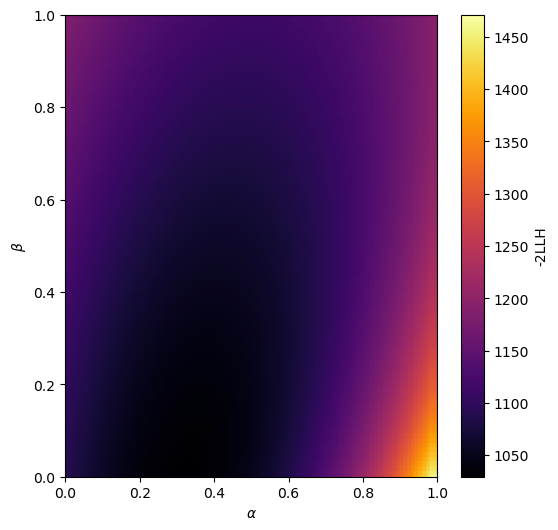

In [267]:
plt.figure(figsize = (6,6))

#raster scan results
sc = plt.scatter(df[r'$\alpha$'],df[r'$\beta$'],c=-2*(df['Intensity']+res.fun),
               marker = 's', s = 100, cmap = 'inferno')

contours = plt.contour(alphas.reshape(len(alpha_range),len(beta_range)),
           betas.reshape(len(alpha_range),len(beta_range)),
          -2*(llhs+res.fun).reshape(len(alpha_range),len(beta_range)),
           [4,4.6,9])


plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

cb = plt.colorbar(sc,label=r'-2LLH')

#### **Exercise 3**

In [268]:
df_MLE = pd.read_csv('MLE_Variance_data.txt', sep='\s+',header=None)
df_MLE.columns = ['X1','X2']
X1 = df_MLE['X1'].values
X2 = df_MLE['X2'].values

In [269]:
def likelihood(x,alpha,beta):
    #we will transform this into a PDF right away...
    pdf = 1+alpha*x+beta*x**2
    #...remembering the PDF should be normalized! this is the definite integral over range -1..1
    norm = 2+(2*beta/3)
    #return the evaluated PDF only inside -1..1 range, and 0 outside
    return np.where(np.abs(x) <= 1, pdf/norm, 0.)

def norm_pdf(x,alpha,beta):
    #we will transform this into a PDF right away...
    pdf = 1+alpha*x+beta*x**2
    #...remembering the PDF should be normalized! this is the definite integral over range -1..1
    norm = 2+(2*beta/3)
    #return the evaluated PDF only inside -1..1 range, and 0 outside
    return pdf/norm

def log_likelihood(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def chi_squared(x_bins, n_obs, alpha, beta):
    # Calculate expected frequencies using the midpoint of each bin
    e_freq = norm_pdf(x_bins, alpha, beta)
    # Normalize expected frequencies to match the total observed counts
    total_obs = np.sum(n_obs)
    e_freq *= total_obs / np.sum(e_freq)
    
    # Calculate chi-squared statistic
    chi2 = np.sum((n_obs - e_freq) ** 2 / e_freq)
    return chi2

In [270]:
lambda_neg_LLH_1 = lambda params: -log_likelihood(X1,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res_1 = minimize(lambda_neg_LLH_1,x0=[0.3,0.3],bounds=((0,1),(0,1)),method='L-BFGS-B')
errors_1 = np.sqrt(np.diag(res_1.hess_inv.todense()))

min_a_1 , min_b_1 = res_1['x']
LLH_1 = res_1.fun

###

lambda_neg_LLH_2 = lambda params: -log_likelihood(X2,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res_2 = minimize(lambda_neg_LLH_2,x0=[0.3,0.3],bounds=((0,1),(0,1)),method='L-BFGS-B')
errors_2 = np.sqrt(np.diag(res_2.hess_inv.todense()))

min_a_2 , min_b_2 = res_2['x']
LLH_2 = res_2.fun

Text(0, 0.5, '$f(x)$')

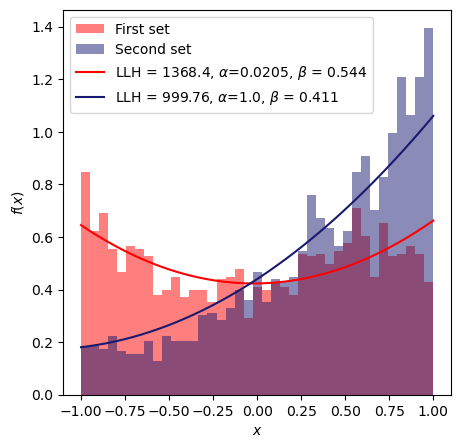

In [271]:
plt.figure(figsize = (5,5))

x_range = np.linspace(-1,1,2000)

plt.hist(X1,bins=np.linspace(-1,1,40),density=True,alpha=0.5,label = 'First set',color='red')
plt.hist(X2,bins=np.linspace(-1,1,40),density=True,alpha=0.5,label = 'Second set',color='midnightblue')
plt.plot(x_range,likelihood(x_range,alpha=min_a_1,beta=min_b_1),
         label=fr'LLH = {LLH_1:.05}, $\alpha$={min_a_1:.03}, $\beta$ = {min_b_1:.03}',linestyle='-',color='red')
plt.plot(x_range,likelihood(x_range,alpha=min_a_2,beta=min_b_2),
         label=fr'LLH = {LLH_2:.05}, $\alpha$={min_a_2:.03}, $\beta$ = {min_b_2:.03}',linestyle='-',color='midnightblue')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')